# 한국어능력평가원
## 목차
### 데이터 전처리
### 발음점수 산정
### 문법점수 산정
### 어휘점수 산정
### 결론 및 Insight


# 데이터 전처리

- Tokenization/Lemmatization
- Cleaning - 영어, 숫자, 기호, 공백 제거
- Stopwords 제거

### 점수 산정에 사용되는 데이터
표본번호, 전체 말뭉치, 말뭉치_포스태깅, 한국어등급, 주제


In [6]:
### Setting
# !pip3 install pandas
# !pip3 install numpy
# !pip3 install xlrd
# !pip3 install openpyxl
# !pip3 install PyKomoran

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from PyKomoran import *
import re

plt.rc('font', family='Nanum Gothic')
mpl.rcParams['axes.unicode_minus'] = False

# path = "/content/drive/MyDrive/텍스트마이닝"
path = "/content/drive/MyDrive/Colab Notebooks/"
### path가 base, 사용되는 파일들은 하위경로 텍스트마이닝에 있음.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### sample df
df_org = pd.DataFrame()

def read_sampleData(dir):

  df_tmp = pd.DataFrame()

  for filename in os.listdir(dir):
    file_path = os.path.join(dir, filename)
    xls_data = pd.read_excel(file_path, keep_default_na=False) ### keep_default_na=False - 형태 주석 'NA'와 null 값 구분

    ### 주제 추가
    subject = dir.split('_')[1].split('/')[0]
    xls_data['주제'] = subject
    ### 데이터 병합
    df_tmp = pd.concat([df_tmp, xls_data])

  return df_tmp

xls_dir1 = path+'텍스트마이닝/말뭉치/말뭉치_자기소개/'
xls_dir2 = path+'텍스트마이닝/말뭉치/말뭉치_한국생활/'

# df_org1 = read_sampleData(xls_dir1)
# df_org2 = read_sampleData(xls_dir2)
# df_org = pd.concat([df_org1,df_org2])

### DataFrame to CSV
df_org_csv = path+'텍스트마이닝/df_origin.csv'
# df_org.to_csv(df_org_csv, index=False)

df_org = pd.read_csv(df_org_csv)

print(len(df_org['표본 번호'].unique()))
df_org.info()

Mounted at /content/drive


FileNotFoundError: ignored

## 점수산정 데이터 전처리

In [ ]:
### 사용할 df 생성
df_dataSubject = df_org.groupby(['표본 번호', '주제'])['문장'].apply(lambda x: ' '.join(x.unique())).reset_index()

print(len(df_dataSubject['표본 번호'].unique()))
df_dataSubject.head(3)

144


,표본 번호,주제,문장
0,4956,한국생활,네 시작하세요. 어 아 안녕하세요 어 지금 저는 한국 생활에 대해 발표하도록 하겠습...
1,4975,한국생활,시작하세요. 저는 중구 여학생입니다. 한국에서 온 지 네 개월 되었습니다. 좋은 중...
2,4976,한국생활,음! 어 안녕하세요? 어 한국에 어 온 지 세 개월 왔어요. 어 한국에 정은 와써 ...


In [ ]:
### 표본 번호 별 한국어 등급 추가
# df_sample_info = pd.DataFrame()
df_sample_info = pd.read_excel(path+"텍스트마이닝/2015~2022 학습자 말뭉치 표본 정보.xlsx", keep_default_na=False)

df_dataLevel = pd.merge(df_dataSubject, df_sample_info[['표본ID', '한국어 등급']], left_on='표본 번호', right_on='표본ID', how='left').drop('표본ID', axis=1)
df_dataLevel.head(3)

,표본 번호,주제,문장,한국어 등급
0,4956,한국생활,네 시작하세요. 어 아 안녕하세요 어 지금 저는 한국 생활에 대해 발표하도록 하겠습...,2급
1,4975,한국생활,시작하세요. 저는 중구 여학생입니다. 한국에서 온 지 네 개월 되었습니다. 좋은 중...,2급
2,4976,한국생활,음! 어 안녕하세요? 어 한국에 어 온 지 세 개월 왔어요. 어 한국에 정은 와써 ...,2급


## Cleaning, Tokenization & Tagging Pos, Stopwords 제거

In [ ]:
### import Stopwords
stopwordsFile = open(path + "텍스트마이닝/koreanStopwords.txt", 'r', encoding="utf-8")
stopwords = []

while True:
    line = stopwordsFile.readline()
    if not line:
        break
    form, pos, _ = line.split()
    stopwords.append([form, pos])

stopwordsFile.close()

### import komoran
komoran = Komoran("EXP")

### Cleaning 패턴
pattern_english = r'[a-zA-Z]+'
pattern_number = r'\d+'
pattern_symbol = r'[!@#$%^&*()_+-={}\[\]:;"\'<>,.?/~`|]'
pattern_empty = r'\s\s+'
exclude_tags = ['SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH', 'SW', 'NF', 'NV', 'SN']

### 전처리 함수
def preprocessing(text):
    ### 영어, 숫자, 기호, 이중공백 제거
    text = re.sub(pattern_english, '', text)
    text = re.sub(pattern_number, '', text)
    # text = re.sub(pattern_symbol, '', text)
    text = re.sub(pattern_empty, '', text)

    ### 문장 토큰화 및 pos tagging
    tokens_tmp = komoran.get_plain_text(text).split(' ')

    tokens = [token for token in tokens_tmp if not any(tag in token for tag in exclude_tags)]

    df_komoran = pd.DataFrame([x.split('/') for x in tokens], columns=['형태소', '주석'])
    # print(tokens)
    # print(df_komoran)

    ### null 값 제거
    df_komoran = df_komoran[df_komoran['주석'].notna()]

    ### Stopwords 제거
    for f, p in stopwords:
        df_komoran = df_komoran[~((df_komoran["형태소"] == f) & (df_komoran["주석"] == p))]

    ### 결과
    result = df_komoran.apply(lambda row: f'{row["형태소"]}/{row["주석"]}' if pd.notna(row["주석"]) else f'{row["형태소"]}', axis=1).tolist()
    # print(result)

    return result

### '토큰화' 컬럼 추가
# df_dataLevel['토큰화'] = df_dataLevel['문장'].apply(lambda x: preprocessing(x))
# df_dataLevel['토큰화'] = ""
# for index, row in df_dataLevel.iterrows():
#     df_dataLevel.at[index, '토큰화'] = preprocessing(row['문장'])

# df_dataLevel.head(13)

In [40]:
### DataFrame to CSV
path = "" # path = "/content/drive/MyDrive/Colab Notebooks/" 코랩에서 실행 시 이걸로 바꾸세요
df_data_csv = path+'텍스트마이닝/df_data.csv'

df_data = pd.read_csv(df_data_csv)


df_data.head(14)

,표본 번호,주제,문장,한국어 등급,토큰화
0,4956,한국생활,네 시작하세요. 어 아 안녕하세요 어 지금 저는 한국 생활에 대해 발표하도록 하겠습...,2급,"['네/MM', '시작/NNG', '하/XSV', '세요/EF', '어/IC', '..."
1,4975,한국생활,시작하세요. 저는 중구 여학생입니다. 한국에서 온 지 네 개월 되었습니다. 좋은 중...,2급,"['시작/NNG', '하/XSV', '세요/EF', '저/NP', '는/JX', '..."
2,4976,한국생활,음! 어 안녕하세요? 어 한국에 어 온 지 세 개월 왔어요. 어 한국에 정은 와써 ...,2급,"['음/IC', '어/IC', '안녕하세요/IC', '어/IC', '한국/NNP',..."
3,4981,한국생활,<name1> 씨? 안녕하십니까 반갑습니다 저는 <name1>입니다. 중국 사람입니...,1급,"['안녕하십니까/NNP', '반갑습니다/NNP', '저/NP', '는/JX', 'ㅂ..."
4,4982,한국생활,하십시오 저는 유럴에 한국에 왔습니다. 한국말럴 배우러 한국에 왔습니다. 음 어 어...,1급,"['시/EP', 'ㅂ시오/EC', '저/NP', '는/JX', '유러/NNG', '..."
5,4985,한국생활,아 사워 십팔 일에 오빠 두 명하고 사촌 오빠 두 명하고 한국에서 아 여행했어요. ...,1급,"['아/IC', '사/NR', '워/NNP', '십팔/NR', '에/JKB', '오..."
6,4986,한국생활,안녕하십니까? 저는 중국에서 온 <name1>입니다. 저는 유월 이십산 일에 한국에...,1급,"['안녕하십니까/NNP', '저/NP', '는/JX', '중국/NNP', '에서/J..."
7,5067,한국생활,한국에 처음 왔을 때 많은 한국 친구를 사귀고 싶었습니다. 그러나 문화가 다르 다르...,5급,"['한국/NNP', '에/JKB', '처음/NNG', '았/EP', '을/ETM',..."
8,5087,한국생활,에 여러부 안녕하세요? 안녕하세요 저는 <name1>입니다. 앞으로 한극 생활에 생...,1급,"['에/IC', '여러/MM', '부/NNB', '안녕하세요/IC', '안녕하세요/..."
9,8170,자기소개,저는 <name1>입니다. 중국 사람입니다. 지금 한국에서 항국말을 배웁니다. 어 ...,1급,"['저/NP', '는/JX', 'ㅂ니다/EF', '중국/NNP', 'ㅂ니다/EF',..."


In [41]:
def process_tokenization_column(tokenization_column):
    result_list = tokenization_column.replace('[', '').replace(']', '').replace("'", "").split(', ')
    return result_list

df_data['토큰화'] = df_data['토큰화'].apply(process_tokenization_column)

# 발음점수 산정

# 문법점수 산정

# 어휘점수 산정

In [45]:
# 다양한 형태소 체크
# 어휘 점수 = 어후 다양성 점수 + 단어 길이 점수 + 형태소 점수 + 어휘 등급 점수
# 어휘 다양성 점수 = (중복되지 않은 어휘 수 / 전체 어휘 수) * 100
# 단어 길이 점수 = (단어 길이 평균 / 5) * 100
# 형태소 점수 = (중복되지 않은 형태소 수 / 전체 형태소 수) * 100

# 형태소 점수
def getHyungTaeSoScore(tokens):
# tokens는 ['저/NP', '는/JX', 'ㅂ니다/EC', '아/IC', '저/NP', '는/...	이렇게 생김.
# 이 중에서 NP, JX, EC, IC, NP, ... 만 추출해서 중복 제거 후 길이 구함.
    
    tokens = [token.split('/')[1] for token in tokens]

    # print(tokens)
    hyungTaeSoScore = (len(set(tokens)) / len(tokens)) * 100

    # vocabScore = (len(set(tokens)) / len(tokens)) * 100
    return hyungTaeSoScore

# 어휘 다양성 점수
def getVocabScore(tokens):
    tokens = [token.split('/')[0] for token in tokens]

    # print(tokens)
    vocabScore = (len(set(tokens)) / len(tokens)) * 100
    return vocabScore

# 단어 길이 점수
def getWordLengthScore(tokens):
    tokens = [token.split('/')[0] for token in tokens]

    # print(tokens)
    wordLengthScore = (sum([len(token) for token in tokens]) / len(tokens)) / 5 * 100
    return wordLengthScore

# 



df_data['형태소 점수'] = df_data['토큰화'].apply(lambda x: getHyungTaeSoScore(x))
df_data['어휘 다양성 점수'] = df_data['토큰화'].apply(lambda x: getVocabScore(x))
df_data['단어 길이 점수'] = df_data['토큰화'].apply(lambda x: getWordLengthScore(x))

df_data.head(10)


# 데이터 중 어휘 점수가 70점이 넘는 데이터 출력
# df_data[df_data['형태소 점수'] > 70].head(10)






,표본 번호,주제,문장,한국어 등급,토큰화,형태소 점수,어휘 다양성 점수,단어 길이 점수
0,4956,한국생활,네 시작하세요. 어 아 안녕하세요 어 지금 저는 한국 생활에 대해 발표하도록 하겠습...,2급,"[네/MM, 시작/NNG, 하/XSV, 세요/EF, 어/IC, 아/IC, 안녕하세요...",5.075188,33.834586,30.000000
1,4975,한국생활,시작하세요. 저는 중구 여학생입니다. 한국에서 온 지 네 개월 되었습니다. 좋은 중...,2급,"[시작/NNG, 하/XSV, 세요/EF, 저/NP, 는/JX, 중구/NNP, 여학생...",5.957447,34.680851,31.574468
2,4976,한국생활,음! 어 안녕하세요? 어 한국에 어 온 지 세 개월 왔어요. 어 한국에 정은 와써 ...,2급,"[음/IC, 어/IC, 안녕하세요/IC, 어/IC, 한국/NNP, 에/JKB, 어/...",4.054054,31.681682,28.588589
3,4981,한국생활,<name1> 씨? 안녕하십니까 반갑습니다 저는 <name1>입니다. 중국 사람입니...,1급,"[안녕하십니까/NNP, 반갑습니다/NNP, 저/NP, 는/JX, ㅂ니다/EF, 중국...",11.557789,45.226131,35.276382
4,4982,한국생활,하십시오 저는 유럴에 한국에 왔습니다. 한국말럴 배우러 한국에 왔습니다. 음 어 어...,1급,"[시/EP, ㅂ시오/EC, 저/NP, 는/JX, 유러/NNG, ㄹ/JKO, 에/JK...",7.540984,37.377049,32.393443
5,4985,한국생활,아 사워 십팔 일에 오빠 두 명하고 사촌 오빠 두 명하고 한국에서 아 여행했어요. ...,1급,"[아/IC, 사/NR, 워/NNP, 십팔/NR, 에/JKB, 오빠/NNG, 두/MM...",9.322034,31.779661,28.983051
6,4986,한국생활,안녕하십니까? 저는 중국에서 온 <name1>입니다. 저는 유월 이십산 일에 한국에...,1급,"[안녕하십니까/NNP, 저/NP, 는/JX, 중국/NNP, 에서/JKB, ㄴ/ETM...",4.710921,34.047109,32.805139
7,5067,한국생활,한국에 처음 왔을 때 많은 한국 친구를 사귀고 싶었습니다. 그러나 문화가 다르 다르...,5급,"[한국/NNP, 에/JKB, 처음/NNG, 았/EP, 을/ETM, 은/ETM, 한국...",1.808439,24.514401,33.261889
8,5087,한국생활,에 여러부 안녕하세요? 안녕하세요 저는 <name1>입니다. 앞으로 한극 생활에 생...,1급,"[에/IC, 여러/MM, 부/NNB, 안녕하세요/IC, 안녕하세요/NNP, 저/NP...",13.609467,46.153846,31.242604
9,8170,자기소개,저는 <name1>입니다. 중국 사람입니다. 지금 한국에서 항국말을 배웁니다. 어 ...,1급,"[저/NP, 는/JX, ㅂ니다/EF, 중국/NNP, ㅂ니다/EF, 지금/MAG, 한...",11.111111,41.798942,32.804233


findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
findfont: Font family 'Nanum Gothic' not found.
/Users/yeonjaeim/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50612 (\N{HANGUL SYLLABLE EO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yeonjaeim/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 55064 (\N{HANGUL SYLLABLE HWI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yeonjaeim/Library/Python/3.11/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from current font.
  fig.canvas.pri

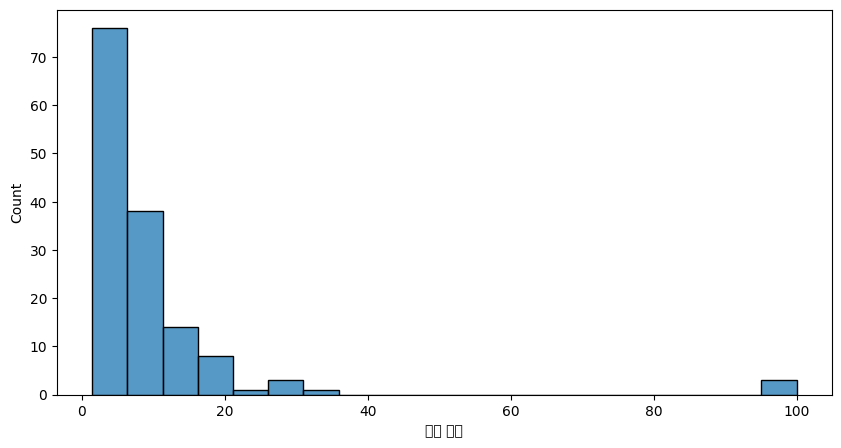

In [39]:
### 어휘 점수 분포
plt.figure(figsize=(10, 5))
sns.histplot(df_data['어휘 점수'], bins=20)
plt.show()



# 결론 및 인사이트